In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import numpy as np
from scipy.signal import argrelextrema, savgol_filter
import wfdb.processing
import warnings
warnings.filterwarnings("ignore")

In [3]:
# defining a function used for rolling mean
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# defining a function for finding minimum
def find_mins(a, num_mins, window):
    found_mins = []
    amax = a.max()
    hwindow = window // 2 
    a = np.array(a)
    for i in range(num_mins):
        found_min = np.argmin(a)
        found_mins.append(found_min)
        a[found_min-hwindow:found_min+hwindow] = amax      
    del a   
    return sorted(found_mins)

# ECG R peak detection
def R_detection(ECG_signal, fs=500):
    ECG = np.array(ECG_signal)
    rpeaks = wfdb.processing.xqrs_detect(ECG, fs=fs, verbose=False)
    rpeaks_corrected = wfdb.processing.correct_peaks(
    ECG, rpeaks, search_radius=200, smooth_window_size=50, peak_dir="up")
    df_ECG = pd.DataFrame(ECG, columns=["ECG"]) 
    df_ECG["R_peak"]= np.nan
    df_ECG.R_peak.iloc[rpeaks_corrected] = df_ECG.ECG.iloc[rpeaks_corrected]
    return df_ECG
    
# c;eaning outlier of dataset
def OutLier(series, max_diff, mean_window):
    data_clear = np.array(series, dtype=np.float64)
    data_outlier = np.abs(series[1:]-series[:-1])>max_diff
    data_outlier = np.append(data_outlier, False)
    data_clear[data_outlier] = np.nan
    data_roll_mean = np.nanmean(rolling_window(data_clear, mean_window), axis=-1)
    data_clear[np.isnan(data_clear)] = data_roll_mean[np.isnan(data_clear)[:1-mean_window]]
    assert np.isnan(data_clear).sum() == 0
    return data_clear

In [4]:
PP_R = []
PP_PPT_b = []
PP_PPT_T = []
Age = []
Weight = []
Height = []
Systol = []
Diastol = []

path = os.path.join(os.getcwd(), "dataset")
dataset_dir = os.listdir(path)
for file in dataset_dir:
    f = open(os.path.join(path, file), 'r')
    data = json.load(f)
    # replacing the outlier data in FSR signal with local mean values
    data_FSR = -np.array(data['data_FSR'])
    data_FSR_clear = OutLier(data_FSR,max_diff = 50, mean_window = 10)
    # smoothing the clerad FSR signal
    data_FSR_smooth = savgol_filter(data_FSR_clear, 51, 0)
    # finding measurment points in data based on transition in cleardFSR signal
    diff_n = 1000
    roll_window = 21
    data_FSR_diff = data_FSR_smooth[diff_n:] - data_FSR_smooth[:-diff_n]
    data_FSR_diff_roll = rolling_window(data_FSR_diff, roll_window).mean(axis=-1)
    # identifingg the measurment points
    num_mins = len(data['data_BP'])
    min_window = 15000
    data_FSR_mins = find_mins(data_FSR_diff_roll, num_mins, min_window)

    # find min and max in PPG signal
    data_PPG = np.array(data['data_PPG'])
    data_PPG_clear = OutLier(data_PPG, max_diff = 50, mean_window = 10)
    data_PPG_clear = savgol_filter(data_PPG_clear, 51, 0)
    df = pd.DataFrame(data_PPG_clear, columns=['data'])
    n = 5  
    df['min'] = df.iloc[argrelextrema(df.data.values, np.less_equal,
                        order=n)[0]]['data']
    df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal,
                        order=n)[0]]['data']
    df_PPG = df
    #  ECG signal and R detection
    df_ECG = R_detection(data['data_ECG'])
    # feature extraction from each sample
    for idx in range(len(data_FSR_mins)):
        if data_FSR_mins[idx]>20000:
            ECG = df_ECG.ECG[data_FSR_mins[idx]-20000:data_FSR_mins[idx]]
            r_peak = df_ECG.R_peak[data_FSR_mins[idx]-20000:data_FSR_mins[idx]]


            PPG = df_PPG.data[data_FSR_mins[idx]-20000:data_FSR_mins[idx]]
            PPG_min = df_PPG['min'][data_FSR_mins[idx]-20000:data_FSR_mins[idx]]
            PPG_max = df_PPG['max'][data_FSR_mins[idx]-20000:data_FSR_mins[idx]]
            # R-R duration
            rr = np.array(r_peak.dropna().index)
            mean_rr = np.mean(rr[1:]-rr[:-1])
            PP_R.append(mean_rr)
            # PTT_b peak to peak time 
            clear_ptt_b = []
            ptt_b = np.array(PPG_min.dropna().index)
            for i in range(len(ptt_b)-1):
                if ptt_b[i+1]-ptt_b[i]>250:
                    clear_ptt_b.append(ptt_b[i])
                
            clear_ptt_b = np.array(clear_ptt_b)
            mean_ptt_b = np.mean(clear_ptt_b[1:]-clear_ptt_b[:-1])
            PP_PPT_b.append(mean_ptt_b)
            # PTT_t peak to peak time
            clear_ptt_t = []
            ptt_t = np.array(PPG_max.dropna().index)
            for i in range(len(ptt_t)-1):
                if ptt_t[i+1]-ptt_t[i]>250:
                    clear_ptt_t.append(ptt_t[i])
                
            clear_ptt_t = np.array(clear_ptt_t)
            mean_ptt_t = np.mean(clear_ptt_t[1:]-clear_ptt_t[:-1])
            PP_PPT_T.append(mean_ptt_t)
            # Age
            Age.append(data["age"])
            # Weight
            Weight.append(data["weight"])
            # Height
            Height.append(data["height"])
            # Systol
            if data['data_BP'][idx]['SBP']==0:
                Systol.append(np.nan)
            else:
                Systol.append(data['data_BP'][idx]['SBP'])
            # Diastol
            if data['data_BP'][idx]['DBP']==0:
                Diastol.append(np.nan)
            else:
                Diastol.append(data['data_BP'][idx]['DBP'])

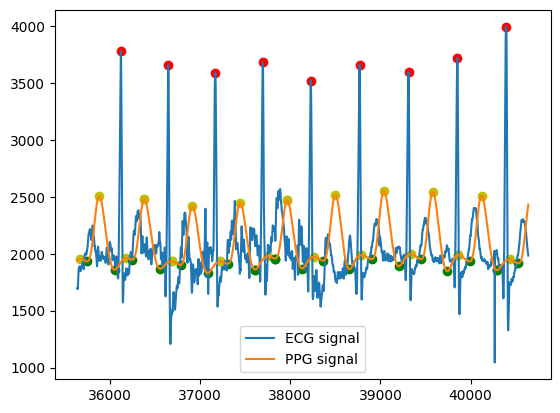

In [4]:
ECG = df_ECG.ECG[data_FSR_mins[0]-5000:data_FSR_mins[0]]
r_peak = df_ECG.R_peak[data_FSR_mins[0]-5000:data_FSR_mins[0]]
plt.scatter(r_peak.index, r_peak, c='r')
plt.plot(ECG, label='ECG signal')

PPG = df_PPG.data[data_FSR_mins[0]-5000:data_FSR_mins[0]]
PPG_min = df_PPG['min'][data_FSR_mins[0]-5000:data_FSR_mins[0]]
PPG_max = df_PPG['max'][data_FSR_mins[0]-5000:data_FSR_mins[0]]
plt.scatter(PPG_max.index, PPG_max, c='y')
plt.scatter(PPG_min.index, PPG_min, c='g')
plt.plot(PPG, label='PPG signal')
plt.legend(loc="best")
plt.show()


In [5]:
feature_Set = pd.DataFrame([Age, Height, Weight, PP_PPT_T, PP_PPT_b, PP_R, Systol, Diastol ])
feature_Set = feature_Set.transpose()
feature_Set.columns = ["age", "height", "weight", "PPT_T", "PPT_B", "R_R", "systol", "diastol"]
feature_Set.to_csv("feature_set.csv", index=False)

In [6]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data = pd.read_csv("feature_set.csv")
data.dropna(inplace=True)
X = data.drop(["systol", "diastol"], axis=1)
y = data.iloc[:,-2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
systol_MSE = np.sqrt(mean_squared_error(y_test.values[:,0], y_pred[:,0]))
diastol_MSE = np.sqrt(mean_squared_error(y_test.values[:,1], y_pred[:,1]))
print(f"MSE of systol pressure estimation: {np.round(systol_MSE,2)}")
print(f"MSE of diastol pressure estimation: {np.round(diastol_MSE,2)}")

MSE of systol pressure estimation: 21.48
MSE of diastol pressure estimation: 9.27
